# Distracting Drivers Recognition with Deep Learning

## 0 Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/dl_project/code

/content/gdrive/My Drive/dl_project/code


In [ ]:
import os
import torch
import matplotlib.pyplot as plt

from image_stats import get_mean_and_std
from image_loader import ImageLoader
from trainer import Trainer
from optimizer import get_optimizer
from vgg16_initial import Vgg16_initial
from vgg16_pretrain import Vgg16_pretrain
from resnet_initial import Resnet_initial
from resnet_pretrain import Resnet_pretrain
from inception_initial import Inception_initial
from inception_pretrain import Inception_pretrain
from alexnet_transfer import AlexNet_Transfer
from alexnet_initial import AlexNet_Initial
#from simple_net import SimpleNet

In [ ]:
is_cuda = True
is_cuda = is_cuda and torch.cuda.is_available() # will turn off cuda if the machine doesnt have a GPU
is_cuda

True

In [ ]:
# root path
data_path = '../data_sub/'
model_path = '../model_save/'
print(os.listdir(data_path))

['train', 'test']


## 1 Datasets Preparation

**Note:**

It takes long to compute the mean and standard deviation of all images. So we just hard code the following results into the code when normalizing the images.

Dataset mean (RGB): \[0.31432810724451854, 0.38041199017110094, 0.3731844571753964\]

Dataset std (RGB):  \[0.2917497236806316, 0.33313283086630213, 0.3350581981547407\]

In [ ]:
# normalization: scale pixel to [0,1] and compute the mean and std of all the images in the dataset
# uncomment the following line to run if needed
# dataset_mean, dataset_std = get_mean_and_std(data_path)

In [ ]:
# print('Dataset mean: ', dataset_mean)
# print('Dataset std: ', dataset_std)

Dataset mean:  [0.31437435026332544, 0.3805657139133703, 0.3733153854924628]
Dataset std:  [0.29172749892553, 0.3331829868413413, 0.3351285321390462]


In [ ]:
# test the dataloader: training dataset
image_loader = ImageLoader(data_path, split='train')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image shape =  torch.Size([3, 96, 128])


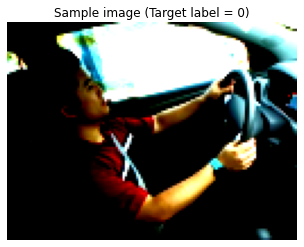

In [ ]:
# get the 0th sample
sample_image, sample_label = next(iter(image_loader))
print('Input image shape = ', sample_image.shape)
fig, axs = plt.subplots()
axs.imshow(sample_image.permute(1,2,0).numpy())
axs.axis('off')
axs.set_title('Sample image (Target label = {})'.format(sample_label))
plt.show()

In [ ]:
# number of images in training set
len(image_loader)

6283

## 2 Training the model

### 2.1 VGG16: pretrain

In [ ]:
vgg16_pretrain_net = Vgg16_pretrain()

In [ ]:
print(vgg16_pretrain_net)

Vgg16_pretrain(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Co

In [ ]:
# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.005,
    "weight_decay": 0.0003,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

In [ ]:
optimizer = get_optimizer(vgg16_pretrain_net, optimize_params)

In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = vgg16_pretrain_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'vgg16_pretrain_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

Epoch:0, Training Loss:2.3013, Validation Loss:2.3020
Epoch:1, Training Loss:2.1749, Validation Loss:2.1818
Epoch:2, Training Loss:1.4091, Validation Loss:1.4341
Epoch:3, Training Loss:0.5210, Validation Loss:0.5686
Epoch:4, Training Loss:0.2194, Validation Loss:0.2756
Epoch:5, Training Loss:0.1083, Validation Loss:0.1624
Epoch:6, Training Loss:0.0618, Validation Loss:0.1203
Epoch:7, Training Loss:0.0396, Validation Loss:0.1030
Epoch:8, Training Loss:0.0279, Validation Loss:0.0868
Epoch:9, Training Loss:0.0173, Validation Loss:0.0724
Epoch:10, Training Loss:0.0154, Validation Loss:0.0762
Epoch:11, Training Loss:0.0108, Validation Loss:0.0708
Epoch:12, Training Loss:0.0085, Validation Loss:0.0661
Epoch:13, Training Loss:0.0071, Validation Loss:0.0620
Epoch:14, Training Loss:0.0056, Validation Loss:0.0619
Epoch:15, Training Loss:0.0049, Validation Loss:0.0611
Epoch:16, Training Loss:0.0043, Validation Loss:0.0607
Epoch:17, Training Loss:0.0039, Validation Loss:0.0589
Epoch:18, Training L

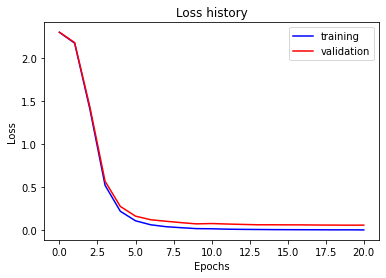

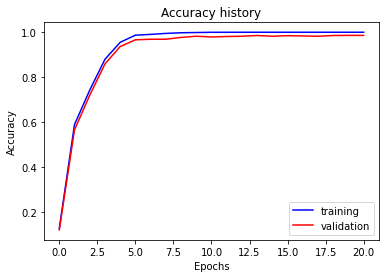

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.9860050890585241

### 2.2 VGG16: initial

In [ ]:
vgg16_initial_net = Vgg16_initial()

# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.003,
    "weight_decay": 0.001,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

optimizer = get_optimizer(vgg16_initial_net, optimize_params)

In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = vgg16_initial_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'vgg16_initial_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

Epoch:0, Training Loss:2.3032, Validation Loss:2.3033
Epoch:1, Training Loss:1.7674, Validation Loss:1.7961
Epoch:2, Training Loss:0.8209, Validation Loss:0.8889
Epoch:3, Training Loss:0.3965, Validation Loss:0.4831
Epoch:4, Training Loss:0.1068, Validation Loss:0.1786
Epoch:5, Training Loss:0.1242, Validation Loss:0.2126
Epoch:6, Training Loss:0.0672, Validation Loss:0.1872
Epoch:7, Training Loss:0.0080, Validation Loss:0.0708
Epoch:8, Training Loss:0.0171, Validation Loss:0.0993
Epoch:9, Training Loss:0.0009, Validation Loss:0.0623
Epoch:10, Training Loss:0.0004, Validation Loss:0.0566
Epoch:11, Training Loss:0.0001, Validation Loss:0.0587
Epoch:12, Training Loss:0.0001, Validation Loss:0.0562
Epoch:13, Training Loss:0.0001, Validation Loss:0.0551
Epoch:14, Training Loss:0.0001, Validation Loss:0.0576
Epoch:15, Training Loss:0.0001, Validation Loss:0.0557
Epoch:16, Training Loss:0.0001, Validation Loss:0.0554
Epoch:17, Training Loss:0.0001, Validation Loss:0.0555
Epoch:18, Training L

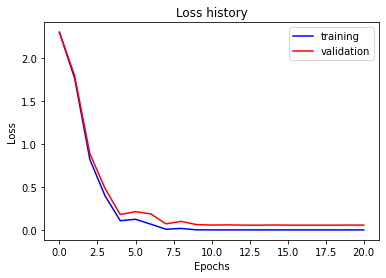

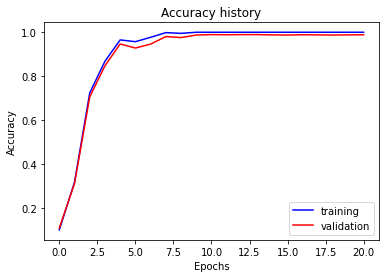

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.9885496183206107

### 2.3 RESNET34: initial

In [ ]:
resnet34_initial_net = Resnet_initial()

# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.003,
    "weight_decay": 0.003,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

optimizer = get_optimizer(resnet34_initial_net, optimize_params)

In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = resnet34_initial_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'resnet34_initial_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

Epoch:0, Training Loss:9.7048, Validation Loss:9.7359
Epoch:1, Training Loss:1.2035, Validation Loss:1.2774
Epoch:2, Training Loss:0.2403, Validation Loss:0.3350
Epoch:3, Training Loss:0.2032, Validation Loss:0.3386
Epoch:4, Training Loss:0.0093, Validation Loss:0.0759
Epoch:5, Training Loss:0.0043, Validation Loss:0.0613
Epoch:6, Training Loss:0.0123, Validation Loss:0.0779
Epoch:7, Training Loss:0.0016, Validation Loss:0.0545
Epoch:8, Training Loss:0.0012, Validation Loss:0.0493
Epoch:9, Training Loss:0.0009, Validation Loss:0.0502
Epoch:10, Training Loss:0.0008, Validation Loss:0.0481
Epoch:11, Training Loss:0.0009, Validation Loss:0.0502
Epoch:12, Training Loss:0.0008, Validation Loss:0.0508
Epoch:13, Training Loss:0.0007, Validation Loss:0.0461
Epoch:14, Training Loss:0.0008, Validation Loss:0.0483
Epoch:15, Training Loss:0.0007, Validation Loss:0.0460
Epoch:16, Training Loss:0.0009, Validation Loss:0.0503
Epoch:17, Training Loss:0.0007, Validation Loss:0.0484
Epoch:18, Training L

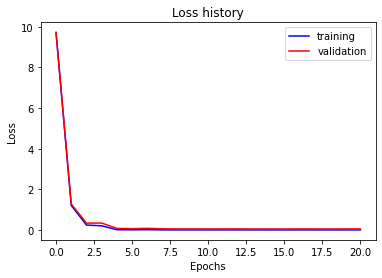

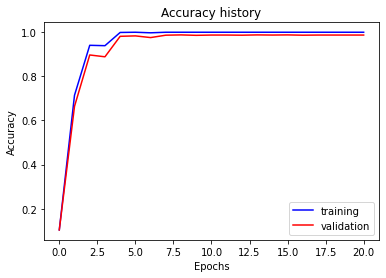

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.9872773536895675

### 2.4 RESNET34: pretrain

In [ ]:
resnet34_pretrain_net = Resnet_pretrain()

# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.008,
    "weight_decay": 0.01,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

optimizer = get_optimizer(resnet34_pretrain_net, optimize_params)

In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = resnet34_pretrain_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'resnet34_pretrain_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

Epoch:0, Training Loss:2.3067, Validation Loss:2.3070
Epoch:1, Training Loss:2.0430, Validation Loss:2.0494
Epoch:2, Training Loss:1.3237, Validation Loss:1.3596
Epoch:3, Training Loss:0.8146, Validation Loss:0.9000
Epoch:4, Training Loss:0.5463, Validation Loss:0.6910
Epoch:5, Training Loss:0.4785, Validation Loss:0.6426
Epoch:6, Training Loss:0.3230, Validation Loss:0.5094
Epoch:7, Training Loss:0.2609, Validation Loss:0.4381
Epoch:8, Training Loss:0.2044, Validation Loss:0.4031
Epoch:9, Training Loss:0.1801, Validation Loss:0.3720
Epoch:10, Training Loss:0.1557, Validation Loss:0.3422
Epoch:11, Training Loss:0.1514, Validation Loss:0.3485
Epoch:12, Training Loss:0.1397, Validation Loss:0.3547
Epoch:13, Training Loss:0.1320, Validation Loss:0.3428
Epoch:14, Training Loss:0.1053, Validation Loss:0.3108
Epoch:15, Training Loss:0.1054, Validation Loss:0.3239
Epoch:16, Training Loss:0.0924, Validation Loss:0.2844
Epoch:17, Training Loss:0.0858, Validation Loss:0.2844
Epoch:18, Training L

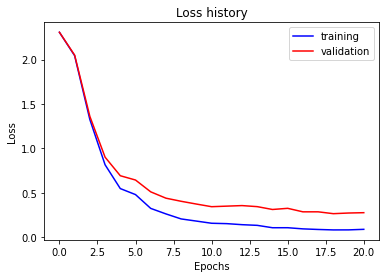

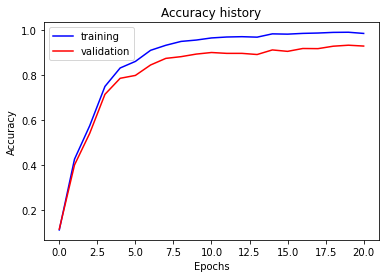

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.9293893129770993

###2.5 Inception: initial 

In [ ]:
inception_initial_net = Inception_initial()

# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.003,
    "weight_decay": 0.003,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

optimizer = get_optimizer(inception_initial_net, optimize_params)

/usr/local/lib/python3.6/dist-packages/torchvision/models/inception.py:77: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = inception_initial_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'inception_initial_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

Epoch:0, Training Loss:2425983.9624, Validation Loss:2443893.7099
Epoch:1, Training Loss:2.7225, Validation Loss:2.7335
Epoch:2, Training Loss:2.0140, Validation Loss:2.0639
Epoch:3, Training Loss:1.5917, Validation Loss:1.6677
Epoch:4, Training Loss:1.0853, Validation Loss:1.1792
Epoch:5, Training Loss:0.6800, Validation Loss:0.8124
Epoch:6, Training Loss:0.4219, Validation Loss:0.5508
Epoch:7, Training Loss:0.3225, Validation Loss:0.4395
Epoch:8, Training Loss:0.2473, Validation Loss:0.3679
Epoch:9, Training Loss:0.1079, Validation Loss:0.2282
Epoch:10, Training Loss:0.1858, Validation Loss:0.3127
Epoch:11, Training Loss:0.1490, Validation Loss:0.2890
Epoch:12, Training Loss:0.0965, Validation Loss:0.2306
Epoch:13, Training Loss:0.0299, Validation Loss:0.1596
Epoch:14, Training Loss:0.0240, Validation Loss:0.1718
Epoch:15, Training Loss:0.0288, Validation Loss:0.1631
Epoch:16, Training Loss:0.0307, Validation Loss:0.1562
Epoch:17, Training Loss:0.0339, Validation Loss:0.1462
Epoch:18

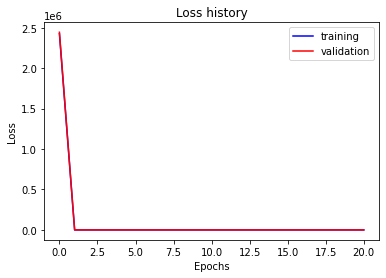

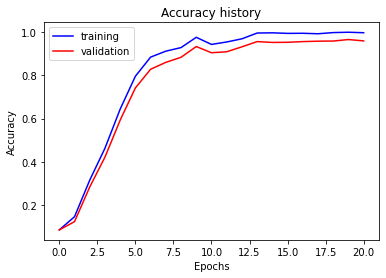

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.9592875318066157

### 2.6 Inception: pretrain

In [ ]:
inception_pretrain_net = Inception_pretrain()

# optimizer settings
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.008,
    "weight_decay": 0.00005,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam

optimizer = get_optimizer(inception_pretrain_net, optimize_params)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
trainer = Trainer(data_dir=data_path, 
                  model = inception_pretrain_net,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'inception_pretrain_net',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=60)

Epoch:0, Training Loss:2.3012, Validation Loss:2.3008
Epoch:1, Training Loss:2.2574, Validation Loss:2.2587
Epoch:2, Training Loss:2.1675, Validation Loss:2.1691
Epoch:3, Training Loss:2.0149, Validation Loss:2.0392
Epoch:4, Training Loss:1.9389, Validation Loss:1.9688
Epoch:5, Training Loss:1.7888, Validation Loss:1.8299
Epoch:6, Training Loss:1.6665, Validation Loss:1.7098
Epoch:7, Training Loss:1.6316, Validation Loss:1.7060
Epoch:8, Training Loss:1.5630, Validation Loss:1.6553
Epoch:9, Training Loss:1.4800, Validation Loss:1.5916
Epoch:10, Training Loss:1.4416, Validation Loss:1.5719
Epoch:11, Training Loss:1.3907, Validation Loss:1.5089
Epoch:12, Training Loss:1.3741, Validation Loss:1.5028
Epoch:13, Training Loss:1.2992, Validation Loss:1.4227
Epoch:14, Training Loss:1.2461, Validation Loss:1.4202
Epoch:15, Training Loss:1.2540, Validation Loss:1.4032
Epoch:16, Training Loss:1.2025, Validation Loss:1.3696
Epoch:17, Training Loss:1.1846, Validation Loss:1.3459
Epoch:18, Training L

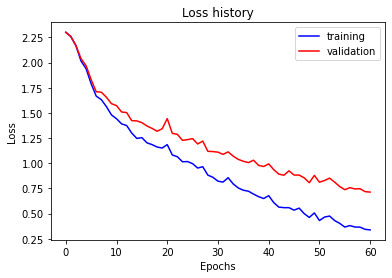

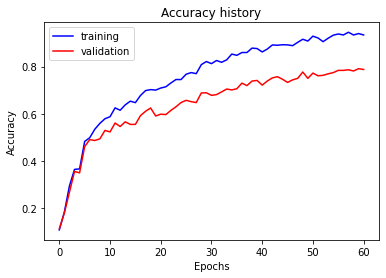

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

0.787531806615776

### 2.7 AlexNet: pretrain

In [ ]:
alexnet_transfer=AlexNet_Transfer()
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.005,
    "weight_decay": 0.0003,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam
optimizer = get_optimizer(alexnet_transfer, optimize_params)
trainer = Trainer(data_dir=data_path, 
                  model = alexnet_transfer,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'alexnet_transfer',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()

In [ ]:
trainer.validation_accuracy_history[-1]

### 2.8 AlexNet: initial

In [ ]:
alexnet_initial=AlexNet_Initial()

In [ ]:
optimize_params = {
    "optimizer_type": "sgd", # can change to "adam"
    "lr": 0.005,
    "weight_decay": 0.005,
    "momentum": 0.9, # parameter for sgd
    "betas": (0.9, 0.999)} # parameter for adam
optimizer = get_optimizer(alexnet_initial, optimize_params)
trainer = Trainer(data_dir=data_path, 
                  model = alexnet_initial,
                  optimizer = optimizer,
                  model_dir = model_path,
                  model_name = 'alexnet_initial',
                  batch_size = 64,
                  cuda = is_cuda)

In [ ]:
trainer.train(num_epochs=20)

In [ ]:
trainer.validation_accuracy_history[-1]

In [ ]:
trainer.plot_loss_history()
trainer.plot_accuracy()